In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/MasterResearch

/content/drive/MyDrive/MasterResearch


In [3]:
from torch import optim, cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


In [4]:
base_dir = "./images"
TEST = 19
default_image_size = tuple((299, 299))
width=299
height=299
depth=3
EPOCHS = 7
INIT_LR = 1e-3
BS = 64

In [5]:
import keras
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import pickle
import os
import pandas as pd
from os import listdir
import shutil
import os.path
import cv2
from keras.preprocessing.image import img_to_array
import math
import numpy as np
from IPython.display import SVG
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px
from shutil import copyfile
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [6]:
data = []
for folder in sorted(os.listdir(base_dir)):
    for file in sorted(os.listdir(base_dir+"/"+folder)):
        data.append((folder, file))

df = pd.DataFrame(data, columns=['Folder', 'File'])


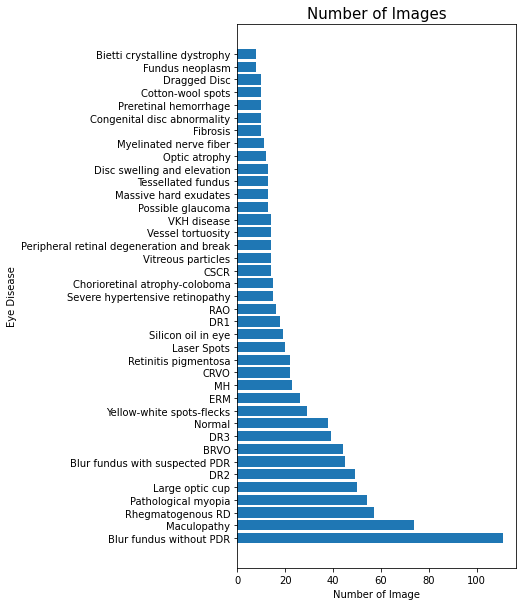

In [ ]:

counts = df['Folder'].value_counts()
plt.figure(figsize=(5,10))
ax = plt.barh(counts.index,counts.values)
#             , title="Number of Images" )
plt.title('Number of Images', fontsize=15)
plt.ylabel("Eye Disease")
plt.xlabel("Number of Image")
plt.show()

In [ ]:


# Add Lighting to the images for improving the visibility 

def draw_img_light(img, sigmaX=10):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128) # the trick is to add this line
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [ ]:
def image_resize(image_path, dim):
  img = cv2.imread(image_path)
  if img.shape[1] != img.shape[0]:
    x = img.shape[1]//2
    y = img.shape[0]//2
    x = x-y
    img = img[0:0+img.shape[0], x:x+img.shape[0]]
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  
def clahe(image_path, denoise=False, limit=None):
    bgr = cv2.imread(image_path)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=(16,32))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr
    
def hist_eq(img):
    img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(img_y_cr_cb)
    img_eq = cv2.equalizeHist(y)
    img_y_cr_cb_eq = cv2.merge((img_eq, cr, cb))
    img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)
    #img=cv2.addWeighted (img_rgb_eq,4, cv2.GaussianBlur( img_rgb_eq , (0,0) , 224/10) ,-4 ,128) # the trick is to add this line 
    return img_rgb_eq


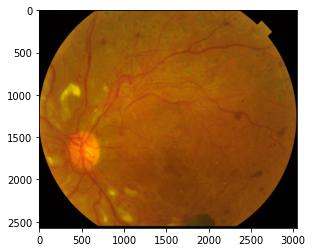

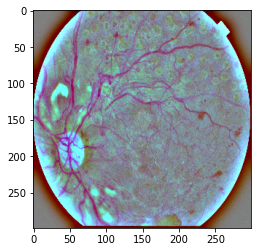

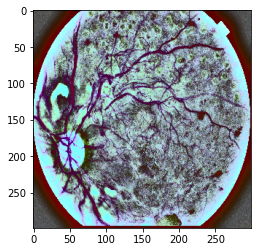

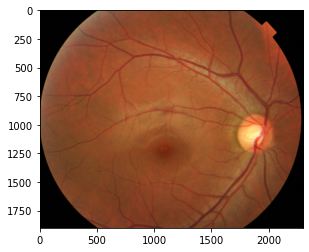

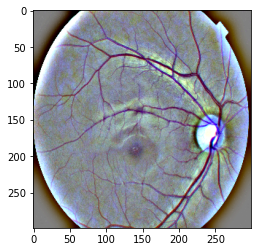

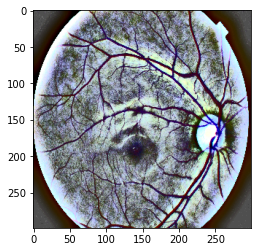

In [ ]:
img_file = './images/DR3/1ffa92e5-8d87-11e8-9daf-6045cb817f5b..JPG'

image = cv2.imread(img_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

plt.imshow(draw_img_light(image))
plt.show()

plt.imshow(hist_eq(draw_img_light(image)))
plt.show()

img_file = './images/Large optic cup/1ffa94d0-8d87-11e8-9daf-6045cb817f5b..JPG'
image = cv2.imread(img_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()
plt.imshow(draw_img_light(image))
plt.show()
plt.imshow(hist_eq(draw_img_light(image)))
plt.show()


In [ ]:
def check_images(image_dir, output_home):
  image_list, label_list = [], [] 
  Total = 0
  Removed_folder = 0
  Kept_folder = 0 
  if os.path.isdir(output_home):
      shutil.rmtree(output_home, ignore_errors=True)
      print("Directory '%s' has been removed successfully" %output_home) 
  if not os.path.isdir(output_home):
      os.mkdir(output_home)
      print("Directory '%s' has been created successfully" %output_home) 
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(image_dir)
      Total = len(root_dir)
      for directory in root_dir :
          # remove .DS_Store from list
          if directory == ".DS_Store" :
              root_dir.remove(directory)
          
      for disease_folder in root_dir :
          eye_disease_image_list = listdir(f"{image_dir}/{disease_folder}")
          eye_images = len(eye_disease_image_list)
          if eye_images > 19:
              Kept_folder = Kept_folder + 1
              print("Keeping Folder: {}".format(disease_folder))
              for single_eye_disease_image in eye_disease_image_list :
                  if single_eye_disease_image == ".DS_Store" :
                      eye_disease_image_list.remove(single_eye_disease_image)
                  else:
                      image_directory = f"{image_dir}/{disease_folder}/{single_eye_disease_image}"
                      if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                          #print(image_directory)
                          output_dir = f"{output_home}/{disease_folder}"
                          if not os.path.isdir(output_dir):
                              os.mkdir(output_dir)
                          output_file = os.path.join(output_dir, single_eye_disease_image)
                          copyfile(image_directory, output_file)
          else:
              Removed_folder = Removed_folder + 1
              print("Removing Folder: {} as it has {} images".format(disease_folder, eye_images))
      print("\n \n Out of Total:{} kept {} and removed {} directory".format(Total, Kept_folder, Removed_folder))

      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")

In [ ]:



base_dir_mod = base_dir + "_test"
check_images(base_dir,base_dir_mod)

Directory './images_test' has been removed successfully
Directory './images_test' has been created successfully
[INFO] Loading images ...
Keeping Folder: BRVO
Keeping Folder: CRVO
Removing Folder: Chorioretinal atrophy-coloboma as it has 15 images
Removing Folder: Cotton-wool spots as it has 10 images
Removing Folder: Congenital disc abnormality as it has 10 images
Keeping Folder: Blur fundus without PDR
Keeping Folder: Blur fundus with suspected PDR
Removing Folder: CSCR as it has 14 images
Removing Folder: Disc swelling and elevation as it has 13 images
Removing Folder: Bietti crystalline dystrophy as it has 8 images
Keeping Folder: DR3
Keeping Folder: DR2
Removing Folder: Dragged Disc as it has 10 images
Keeping Folder: Large optic cup
Keeping Folder: ERM
Keeping Folder: Laser Spots
Keeping Folder: Maculopathy
Removing Folder: DR1 as it has 18 images
Removing Folder: Fibrosis as it has 10 images
Removing Folder: Fundus neoplasm as it has 8 images
Keeping Folder: Normal
Removing Fold

In [ ]:




data = []
for folder in sorted(os.listdir(base_dir_mod)):
    for file in sorted(os.listdir(base_dir_mod+"/"+folder)):
        data.append((folder, file))

df = pd.DataFrame(data, columns=['Folder', 'File'])

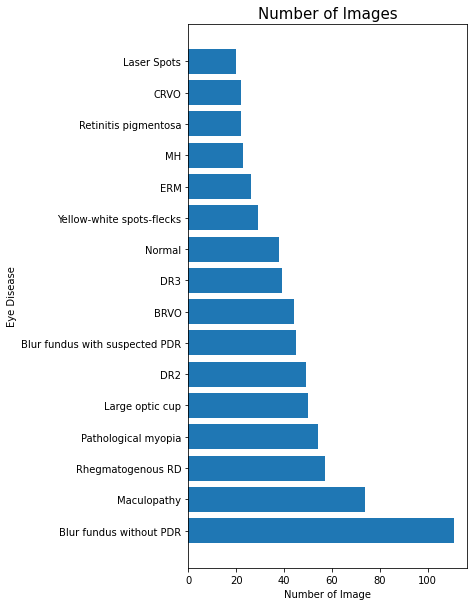

In [ ]:
counts = df['Folder'].value_counts()
plt.figure(figsize=(5,10))
ax = plt.barh(counts.index,counts.values)
#             , title="Number of Images" )
plt.title('Number of Images', fontsize=15)
plt.ylabel("Eye Disease")
plt.xlabel("Number of Image")
plt.show()

In [ ]:
#define croping function with tensorflow resize
def crop_image(image_path):
  image_data = tf.keras.preprocessing.image.load_img(image_path)
  
  array = tf.keras.preprocessing.image.img_to_array(image_data)
  image = tf.image.resize(
                        array, [224,224], 
                        method='bilinear',
                        preserve_aspect_ratio=True,
                        antialias=False,
                        )
  # image = image / 255.0
  return image

In [ ]:
def print_image(path, file_path):
    source = path + '/' + file_path
    test = crop_image(source)
    test = np.array(test)
    img = tf.keras.preprocessing.image.array_to_img(test)
    plt.imshow(img)
    test = np.expand_dims(test, axis=0)
    test.shape
    return None


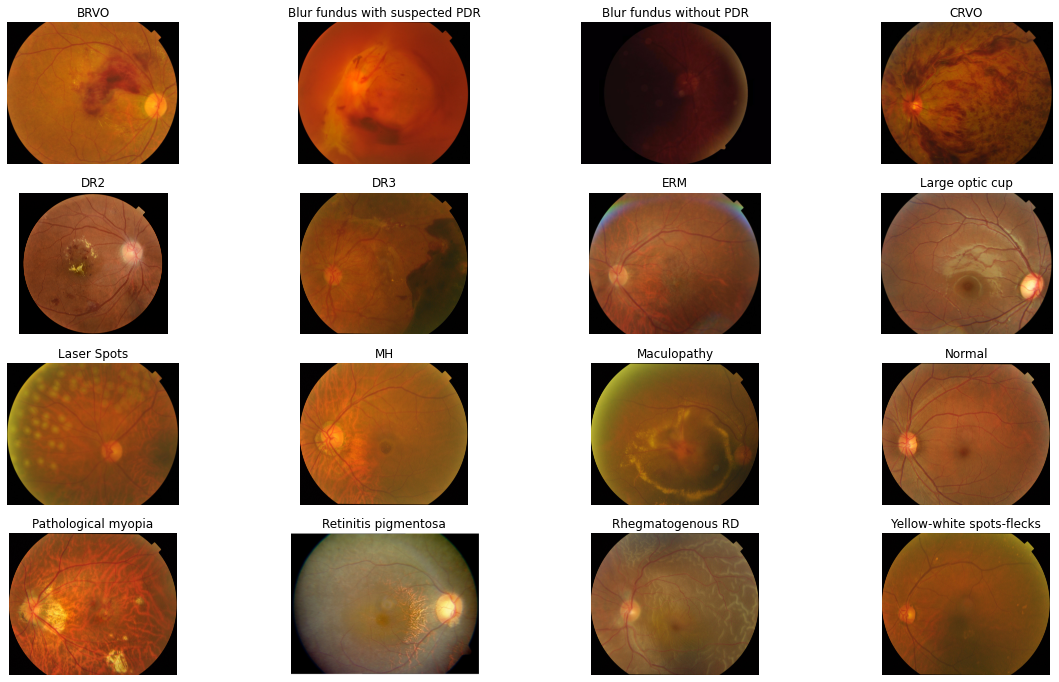

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir_mod + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)
        #test.shape
        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()

    
    



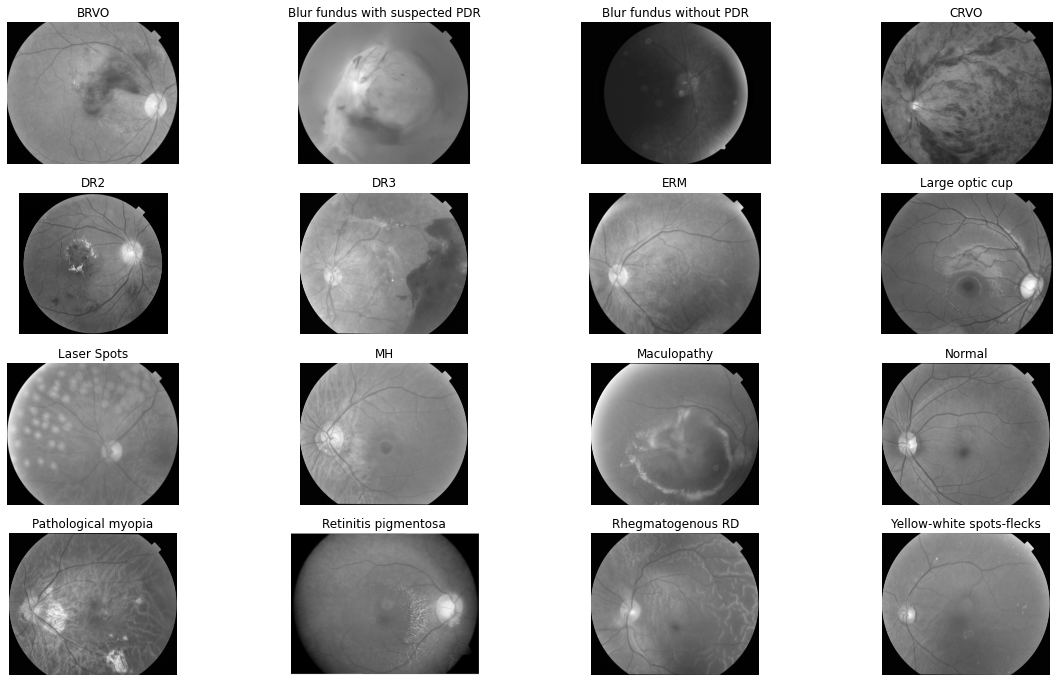

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir_mod + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax.imshow(image, cmap='gray')
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)
        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()


In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image


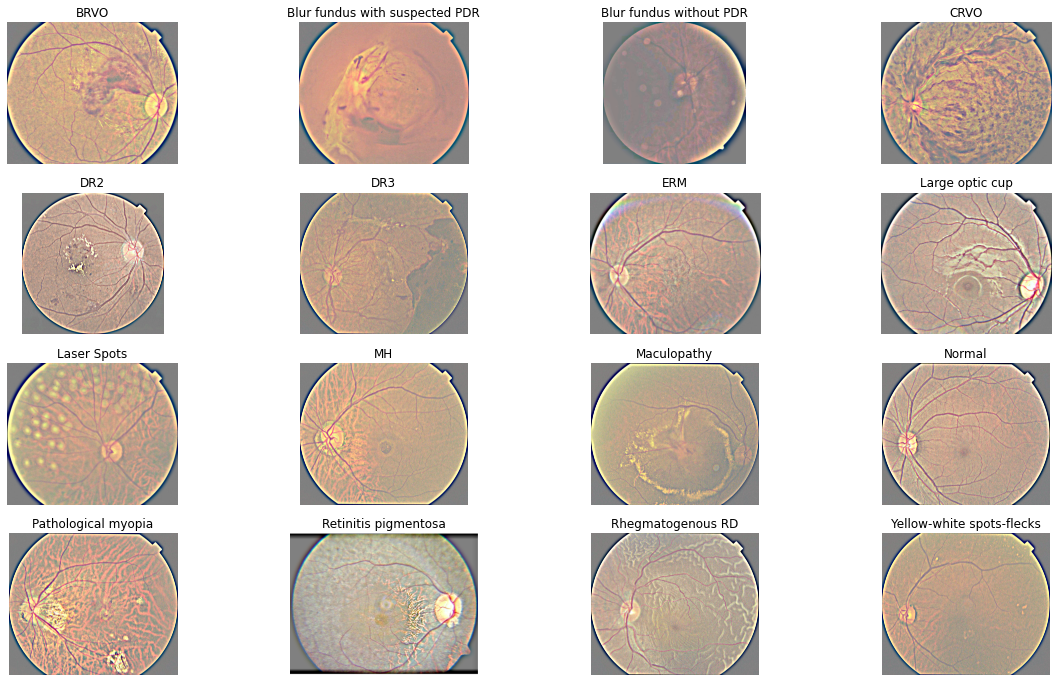

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir_mod + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        image = load_ben_color(source,sigmaX=30)
        #image = cv2.imread(source)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax.imshow(image, cmap='gray')
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)
#        test.shape
        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()


In [ ]:
def convert_image_to_array(image_dir, default_image_size):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :", e)
        return None

In [ ]:
def load_images(image_dir, default_image_size):
  image_list, label_list = [], [] 
  Total = 0
  Removed_folder = 0
  Kept_folder = 0 
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(image_dir)
      Total = len(root_dir)
      for directory in root_dir :
          # remove .DS_Store from list
          if directory == ".DS_Store" :
              root_dir.remove(directory)
          
      for disease_folder in root_dir :
          eye_disease_image_list = listdir(f"{image_dir}/{disease_folder}")
          eye_images = len(eye_disease_image_list)
          print(f"[INFO] Processing {disease_folder} ...")
          for single_eye_disease_image in eye_disease_image_list :
              if single_eye_disease_image == ".DS_Store" :
                  eye_disease_image_list.remove(single_eye_disease_image)
              else:
                  image_directory = f"{image_dir}/{disease_folder}/{single_eye_disease_image}"
                  if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                      #print(image_directory)
                      image_list.append(convert_image_to_array(image_directory, default_image_size))
                      label_list.append(disease_folder)
                                
      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")
  return image_list, label_list

In [ ]:
image_list, label_list = load_images(base_dir_mod, default_image_size)

[INFO] Loading images ...
[INFO] Processing BRVO ...
[INFO] Processing CRVO ...
[INFO] Processing Blur fundus without PDR ...
[INFO] Processing Blur fundus with suspected PDR ...
[INFO] Processing DR3 ...
[INFO] Processing DR2 ...
[INFO] Processing Large optic cup ...
[INFO] Processing ERM ...
[INFO] Processing Laser Spots ...
[INFO] Processing Maculopathy ...
[INFO] Processing Normal ...
[INFO] Processing MH ...
[INFO] Processing Pathological myopia ...
[INFO] Processing Retinitis pigmentosa ...
[INFO] Processing Yellow-white spots-flecks ...
[INFO] Processing Rhegmatogenous RD ...
[INFO] Image loading completed


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(image_labels)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [ ]:
print(label_binarizer.classes_)

['BRVO' 'Blur fundus with suspected PDR' 'Blur fundus without PDR' 'CRVO'
 'DR2' 'DR3' 'ERM' 'Large optic cup' 'Laser Spots' 'MH' 'Maculopathy'
 'Normal' 'Pathological myopia' 'Retinitis pigmentosa' 'Rhegmatogenous RD'
 'Yellow-white spots-flecks']


In [ ]:
#--np_image_list = np.array(image_list, dtype=np.float16) / 255.0
#--print("[INFO] Spliting data to train, test")
#--x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 64)

In [ ]:
def load_ben_color_img(image, sigmaX=10):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [ ]:
def convert(image_dir, output_home, limit=None):
  image_list, label_list = [], []
  if os.path.isdir(output_home):
      shutil.rmtree(output_home, ignore_errors=True)
      print("Directory '%s' has been removed successfully" %output_home) 
  if not os.path.isdir(output_home):
      os.mkdir(output_home)
      print("Directory '%s' has been created successfully" %output_home) 
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(image_dir)
      print(root_dir)
      for directory in root_dir :
          # remove .DS_Store from list
          if directory == ".DS_Store" :
              root_dir.remove(directory)
          
      for disease_folder in root_dir :
          eye_disease_image_list = listdir(f"{image_dir}/{disease_folder}")
          print(eye_disease_image_list)
          for single_eye_disease_image in eye_disease_image_list :
              if single_eye_disease_image == ".DS_Store" :
                  eye_disease_image_list.remove(single_eye_disease_image)
              else:
                  image_directory = f"{image_dir}/{disease_folder}/{single_eye_disease_image}"
                  if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                      print(image_directory)
                    
                      bgr = clahe(image_directory, limit=limit)
                      bgr = hist_eq(bgr)
                      #bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
                      
                      #green_image = bgr.copy()
                      #green_image[:,:,0] = 0
                      #green_image[:,:,2] = 0
                      #bgr = green_image
                      #bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
                      #bgr = load_ben_color_img(bgr,sigmaX=30)
                      bgr = crop_image_from_gray(bgr)


                      output_dir = f"{output_home}/{disease_folder}"
                      if not os.path.isdir(output_dir):
                          os.mkdir(output_dir)
                      output_file = os.path.join(output_dir, single_eye_disease_image)
                      cv2.imwrite(output_file, bgr)

      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")

In [ ]:
base_dir_mod
output_home_dir = "./images_modified"
limit = 2.0
convert(base_dir_mod, output_home_dir, limit=limit)

Directory './images_modified' has been removed successfully
Directory './images_modified' has been created successfully
[INFO] Loading images ...
['BRVO', 'CRVO', 'Blur fundus without PDR', 'Blur fundus with suspected PDR', 'DR3', 'DR2', 'Large optic cup', 'ERM', 'Laser Spots', 'Maculopathy', 'Normal', 'MH', 'Pathological myopia', 'Retinitis pigmentosa', 'Yellow-white spots-flecks', 'Rhegmatogenous RD']
['1ffa95f2-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95f1-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95f4-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95f3-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9611-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa960f-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95fb-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9606-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95fd-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9601-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9608-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9604-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9603-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa96

In [ ]:
base_dir = "./images_modified"

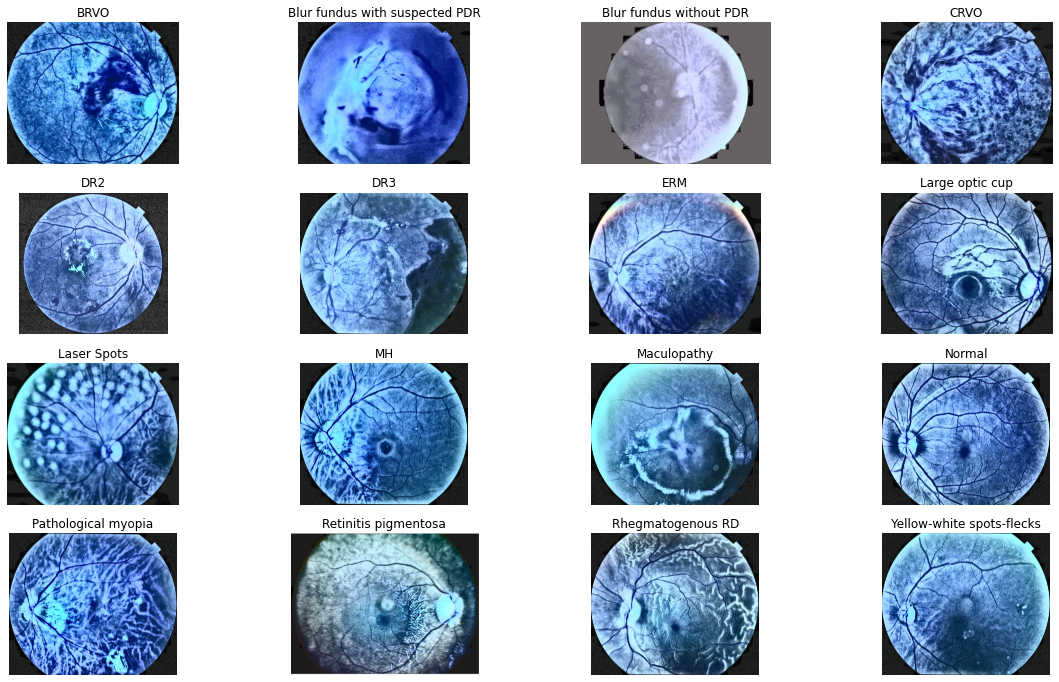

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        #image = load_ben_color(source,sigmaX=30)
        image = cv2.imread(source)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax.imshow(image)
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)

        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()


In [ ]:
#np_image_list = np.array(image_list, dtype=np.float16) / 255.0
#train_x, valid_x, train_y, valid_y = train_test_split(np_image_list, image_labels, test_size=0.20,
#                                                      stratify=y, random_state=2021)
#print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)


In [7]:
base_dir = "./images_modified"
IMAGE_SIZE = 299
BATCH_SIZE = 32

datagen = keras.preprocessing.image.ImageDataGenerator(      rescale = 1/255.0,
                                                            rotation_range=45,
                                                             shear_range = 0.1,
                                                             zoom_range = 0.2,
                                                            brightness_range=[0.2,1.0],
                                                             horizontal_flip=True,
                                                             vertical_flip=True,
                                                             dtype=np.float32,
                                                            validation_split = 0.2,
                                                             fill_mode='constant'
                                                             )


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#train_generator = datagen.flow(train_x, train_y, batch_size=BATCH_SIZE)
#val_generator = datagen.flow(valid_x, valid_y, batch_size=BATCH_SIZE)


Found 570 images belonging to 16 classes.
Found 133 images belonging to 16 classes.


In [8]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 299, 299, 3), (32, 16))

In [9]:
Diseases = list(train_generator.class_indices.keys())
print(Diseases)

['BRVO', 'Blur fundus with suspected PDR', 'Blur fundus without PDR', 'CRVO', 'DR2', 'DR3', 'ERM', 'Large optic cup', 'Laser Spots', 'MH', 'Maculopathy', 'Normal', 'Pathological myopia', 'Retinitis pigmentosa', 'Rhegmatogenous RD', 'Yellow-white spots-flecks']


In [10]:
Diseases = list(train_generator.class_indices.keys())
print(Diseases)

['BRVO', 'Blur fundus with suspected PDR', 'Blur fundus without PDR', 'CRVO', 'DR2', 'DR3', 'ERM', 'Large optic cup', 'Laser Spots', 'MH', 'Maculopathy', 'Normal', 'Pathological myopia', 'Retinitis pigmentosa', 'Rhegmatogenous RD', 'Yellow-white spots-flecks']


In [11]:
# Number of images for each disease
nums = {}
for disease in Diseases:
    nums[disease] = len(os.listdir(base_dir + '/' + disease))
print(nums)

{'BRVO': 44, 'Blur fundus with suspected PDR': 45, 'Blur fundus without PDR': 111, 'CRVO': 22, 'DR2': 49, 'DR3': 39, 'ERM': 26, 'Large optic cup': 50, 'Laser Spots': 20, 'MH': 23, 'Maculopathy': 74, 'Normal': 38, 'Pathological myopia': 54, 'Retinitis pigmentosa': 22, 'Rhegmatogenous RD': 57, 'Yellow-white spots-flecks': 29}


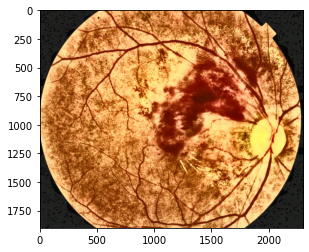

In [12]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
# Take one image to visualize it's changes after every layer
from keras.preprocessing import image
import numpy as np
img1 = image.load_img('./images_modified/BRVO/1ffa95f1-8d87-11e8-9daf-6045cb817f5b..JPG')
plt.imshow(img1);

#preprocess image
img1 = image.load_img('./images_modified/BRVO/1ffa95f1-8d87-11e8-9daf-6045cb817f5b..JPG', target_size=(IMAGE_SIZE, IMAGE_SIZE))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [ ]:
def get_model_imagenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_imagenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [15]:
  def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("cf - " + class_label)


In [ ]:
#SVG(tf.keras.utils.model_to_dot(model, dpi=70, show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, subgraph=False).create(prog='dot', format='svg'))

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    
)



Epoch 1/50
18/18 [==============================] - 94s 5s/step - loss: 2.5722 - accuracy: 0.1983 - val_loss: 2.1304 - val_accuracy: 0.2932
Epoch 2/50
18/18 [==============================] - 85s 5s/step - loss: 1.7399 - accuracy: 0.4754 - val_loss: 1.5050 - val_accuracy: 0.5263
Epoch 3/50
18/18 [==============================] - 85s 5s/step - loss: 1.2766 - accuracy: 0.6395 - val_loss: 1.4292 - val_accuracy: 0.5564
Epoch 4/50
18/18 [==============================] - 85s 5s/step - loss: 0.9927 - accuracy: 0.6997 - val_loss: 1.0676 - val_accuracy: 0.6541
Epoch 5/50
18/18 [==============================] - 85s 5s/step - loss: 0.8490 - accuracy: 0.7406 - val_loss: 0.9927 - val_accuracy: 0.6842
Epoch 6/50
18/18 [==============================] - 84s 5s/step - loss: 0.7887 - accuracy: 0.7258 - val_loss: 0.8216 - val_accuracy: 0.7744
Epoch 7/50
18/18 [==============================] - 84s 5s/step - loss: 0.7206 - accuracy: 0.7685 - val_loss: 0.7848 - val_accuracy: 0.7218
Epoch 8/50
18/18 [==

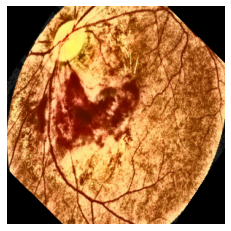

True label: BRVO
Predicted label: BRVO


In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in val_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(val_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [ ]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('inception_adam.h5')

Test loss: 0.40649300813674927
Test Accuracy: 0.8721804618835449


Confusion Matrix
[[0 0 2 0 1 1 1 0 0 1 1 0 0 0 1 0]
 [1 0 2 0 0 2 0 1 0 0 0 0 1 0 1 1]
 [1 2 5 0 0 0 1 2 0 0 2 2 2 1 4 0]
 [0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 1 1 0 1 0 2 0 1 0 1 2 0 0 0 0]
 [0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0]
 [1 1 0 0 2 0 0 2 1 1 1 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 1]
 [0 0 3 0 1 1 0 2 1 1 2 0 0 1 2 0]
 [0 0 3 1 0 0 0 0 1 0 0 0 0 0 2 0]
 [0 0 2 0 0 0 1 1 0 1 3 0 1 0 1 0]
 [0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0]
 [1 1 1 0 2 1 0 1 0 0 1 0 1 1 1 0]
 [0 0 1 1 0 0 0 0 0 1 0 2 0 0 0 0]]



F1 Score macro 0.06246206816059757
F1 Score micro 0.09774436090225563
F1 Score weighted 0.09600857887014456
accuracy_score  0.09774436090225563
precision_score  0.06167792805021066
recall_score  0.06343795093795093
mean_squared_error  42.097744360902254


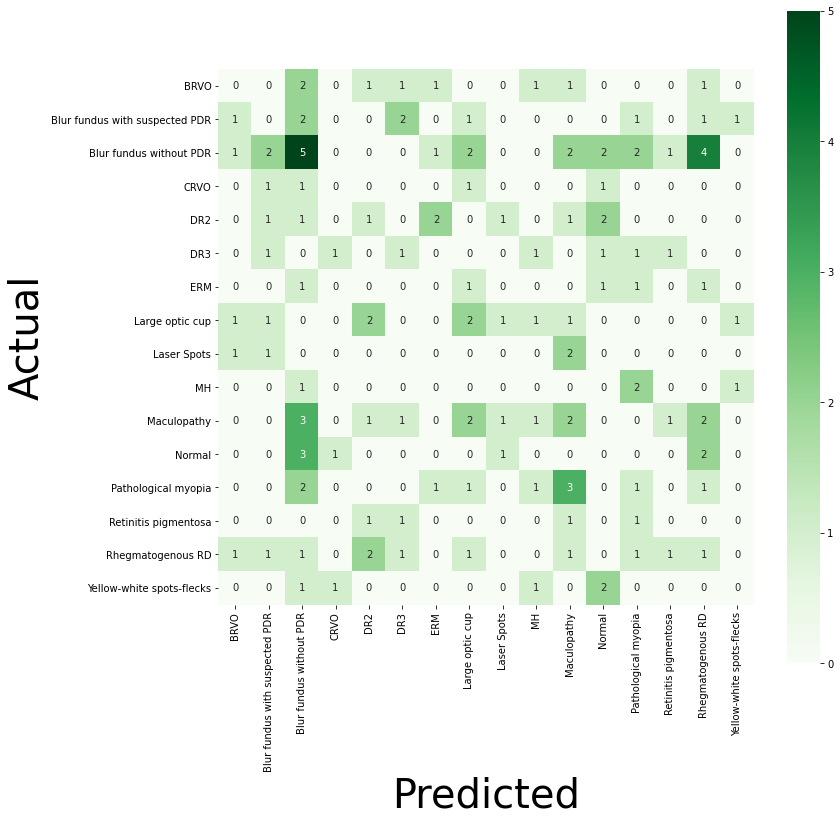

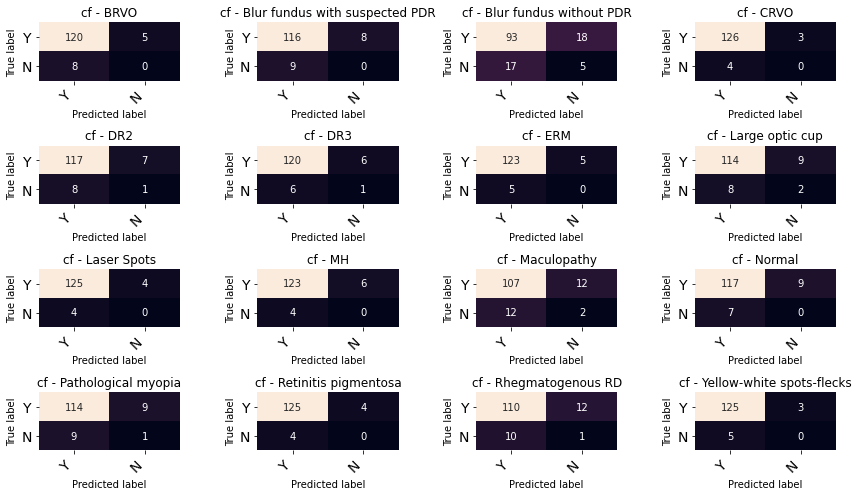

In [ ]:
import sklearn.metrics
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
from sklearn.metrics import f1_score

print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("cf - " + class_label)
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

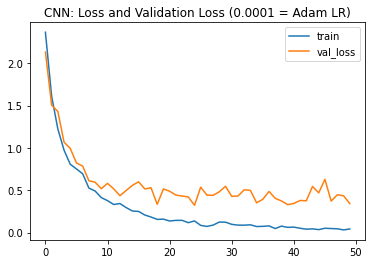

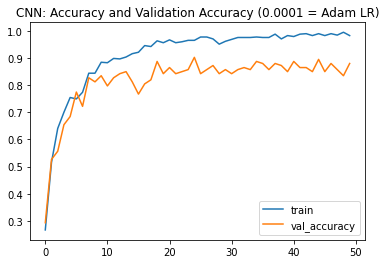

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adam LR)')
plt.legend();
plt.show()

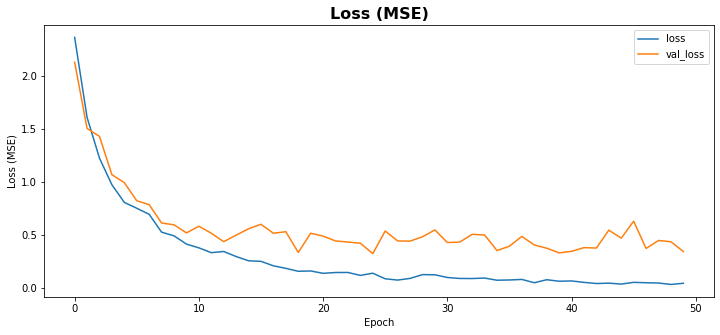

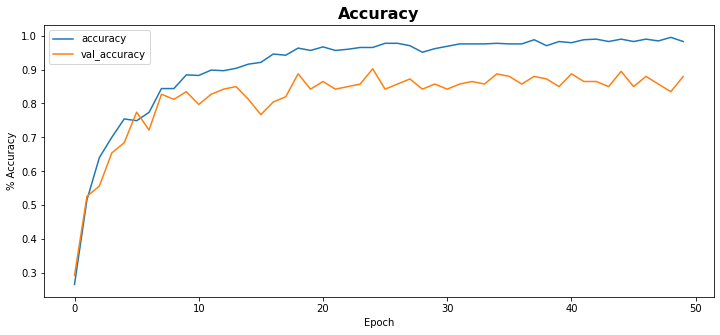

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In [ ]:
def get_model_imagenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_imagenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adamax(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]

)

Epoch 1/50
18/18 [==============================] - 94s 5s/step - loss: 2.6942 - accuracy: 0.1582 - val_loss: 2.1013 - val_accuracy: 0.3459
Epoch 2/50
18/18 [==============================] - 85s 5s/step - loss: 2.0335 - accuracy: 0.3854 - val_loss: 1.8533 - val_accuracy: 0.4361
Epoch 3/50
18/18 [==============================] - 86s 5s/step - loss: 1.7187 - accuracy: 0.5068 - val_loss: 1.6164 - val_accuracy: 0.5038
Epoch 4/50
18/18 [==============================] - 86s 5s/step - loss: 1.6107 - accuracy: 0.5255 - val_loss: 1.4848 - val_accuracy: 0.5414
Epoch 5/50
18/18 [==============================] - 85s 5s/step - loss: 1.4764 - accuracy: 0.5434 - val_loss: 1.3352 - val_accuracy: 0.6241
Epoch 6/50
18/18 [==============================] - 86s 5s/step - loss: 1.2451 - accuracy: 0.6316 - val_loss: 1.2474 - val_accuracy: 0.6015
Epoch 7/50
18/18 [==============================] - 86s 5s/step - loss: 1.1707 - accuracy: 0.6348 - val_loss: 1.2067 - val_accuracy: 0.6165
Epoch 8/50
18/18 [==

In [ ]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('inception_adamax.h5')

Test loss: 0.47393226623535156
Test Accuracy: 0.8571428656578064


Confusion Matrix
[[0 0 2 1 0 0 0 0 0 1 0 1 1 1 1 0]
 [0 0 3 0 0 0 0 1 0 0 0 0 2 0 2 1]
 [2 3 3 0 1 1 1 3 0 0 2 0 2 1 2 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 1]
 [0 0 3 1 1 0 1 0 0 0 1 0 1 0 1 0]
 [0 1 1 0 1 1 0 0 0 0 1 0 1 0 1 0]
 [0 0 1 0 0 1 0 2 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 1 1 1 0 0 2 2 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 2 0 0 0 1 0]
 [0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0]
 [0 2 2 1 2 1 1 1 1 0 1 1 0 0 1 0]
 [0 0 3 0 0 0 1 0 1 1 0 0 1 0 0 0]
 [0 0 2 0 0 0 0 1 1 1 2 0 1 1 1 0]
 [0 2 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [2 0 0 0 2 1 0 1 1 1 1 2 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0]]



F1 Score macro 0.056525072150072145
F1 Score micro 0.06766917293233082
F1 Score weighted 0.06770172183706019
accuracy_score  0.06766917293233082
precision_score  0.0562274531024531
recall_score  0.056985028860028854
mean_squared_error  45.06015037593985


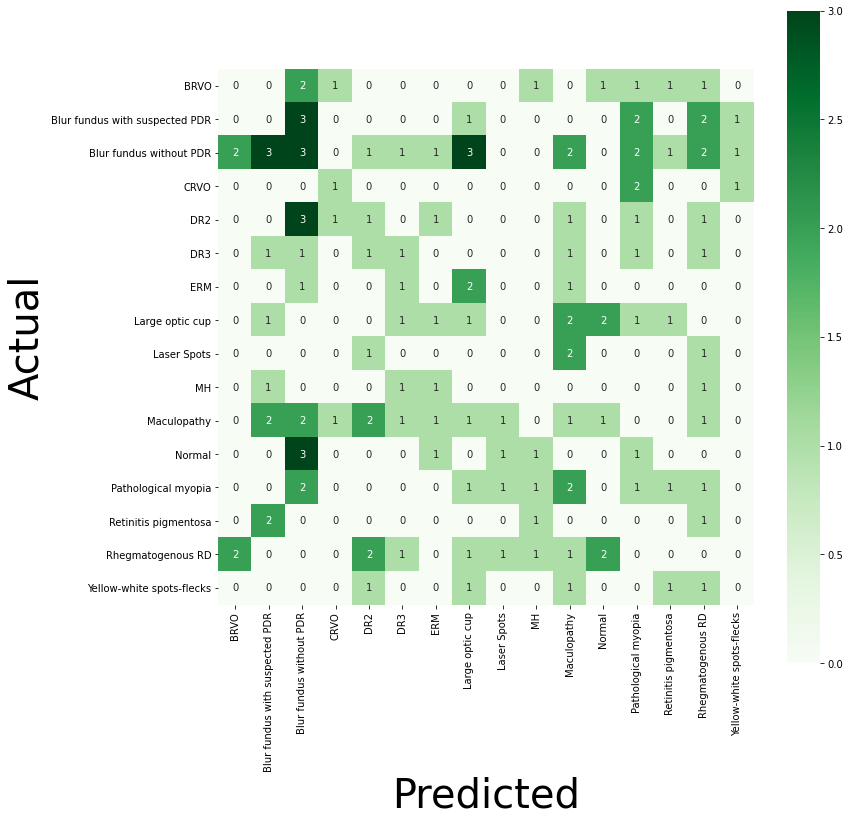

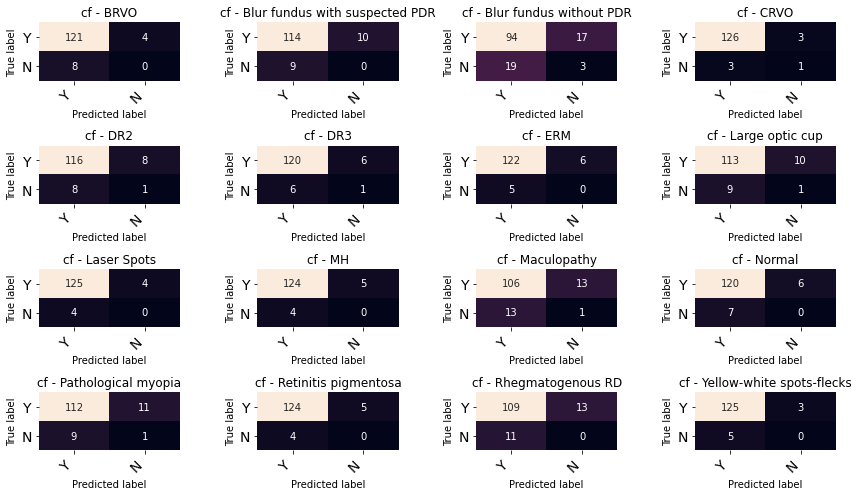

In [ ]:
import sklearn.metrics
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

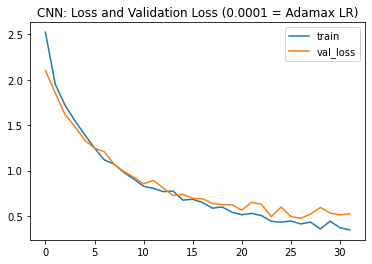

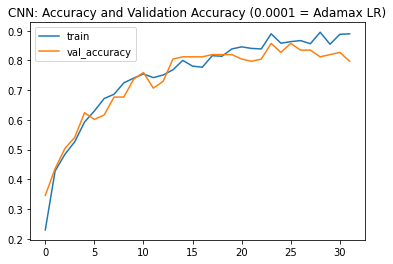

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adamax LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adamax LR)')
plt.legend();
plt.show()

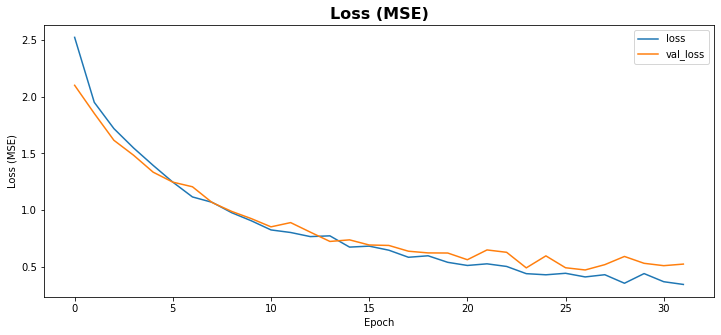

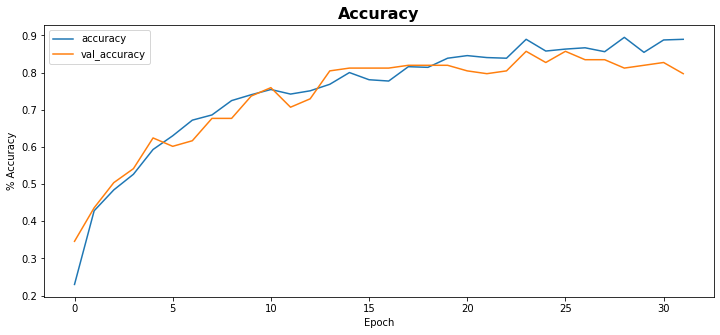

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In [ ]:
def get_model_imagenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_imagenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 97s 5s/step - loss: 2.4453 - accuracy: 0.2599 - val_loss: 1.8763 - val_accuracy: 0.3534
Epoch 2/50
18/18 [==============================] - 87s 5s/step - loss: 1.5144 - accuracy: 0.5400 - val_loss: 1.4145 - val_accuracy: 0.5414
Epoch 3/50
18/18 [==============================] - 86s 5s/step - loss: 1.1254 - accuracy: 0.6667 - val_loss: 1.3062 - val_accuracy: 0.5489
Epoch 4/50
18/18 [==============================] - 86s 5s/step - loss: 0.9128 - accuracy: 0.7154 - val_loss: 1.0969 - val_accuracy: 0.6767
Epoch 5/50
18/18 [==============================] - 86s 5s/step - loss: 0.7568 - accuracy: 0.7501 - val_loss: 0.9197 - val_accuracy: 0.6767
Epoch 6/50
18/18 [==============================] - 86s 5s/step - loss: 0.7477 - accuracy: 0.7670 - val_loss: 0.8155 - val_accuracy: 0.7368
Epoch 7/50
18/18 [==============================] - 86s 5s/step - loss: 0.5577 - accuracy: 0.8366 - val_loss: 0.6178 - val_accuracy: 0.8045
Epoch 8/50
18/18 [==

In [ ]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('inception_RMSprop.h5')

Test loss: 0.5143764019012451
Test Accuracy: 0.8421052694320679


Confusion Matrix
[[0 1 2 1 1 0 0 0 0 0 0 1 1 0 1 0]
 [1 0 1 0 3 1 1 0 0 1 0 1 0 0 0 0]
 [2 0 0 1 0 1 2 5 1 0 3 1 1 2 2 1]
 [0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 3 1 0 0 1 0 0 0 0 1 2 0 1 0]
 [0 0 1 0 1 0 0 0 0 0 2 0 2 0 1 0]
 [0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1]
 [0 1 1 0 1 0 0 2 1 0 1 0 1 0 2 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1]
 [0 2 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 1 2 0 1 1 2 0 0 0 2 0 2 0 1 1]
 [0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 2]
 [1 2 4 0 0 0 0 0 0 1 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0]
 [1 0 2 0 1 0 0 2 0 1 1 1 1 1 0 0]
 [0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0]]



F1 Score macro 0.030400992685475442
F1 Score micro 0.03759398496240601
F1 Score weighted 0.03445526040807347
accuracy_score  0.03759398496240601
precision_score  0.027678571428571427
recall_score  0.03392857142857143
mean_squared_error  45.03007518796993


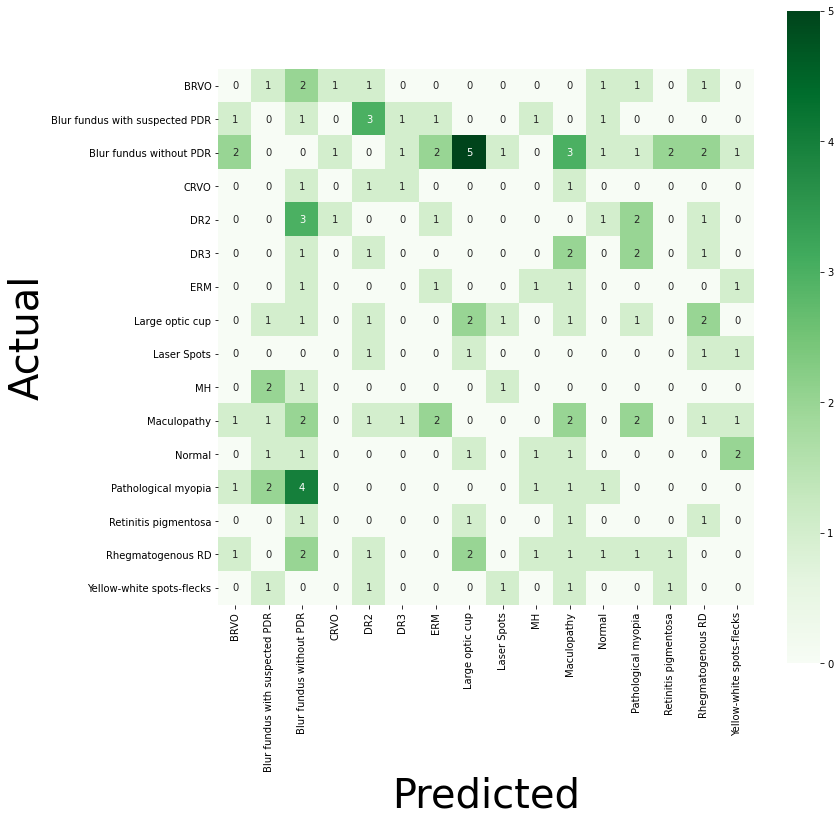

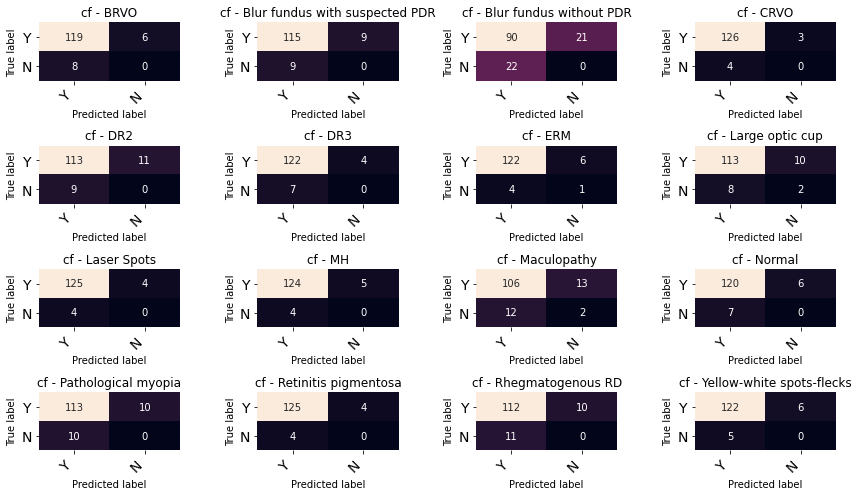

In [ ]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

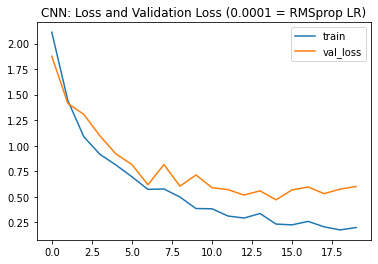

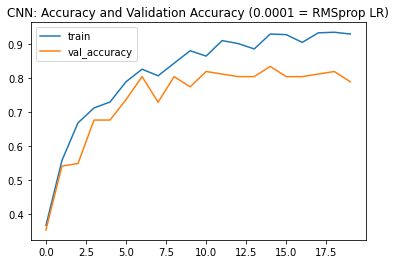

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = RMSprop LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = RMSprop LR)')
plt.legend();
plt.show()

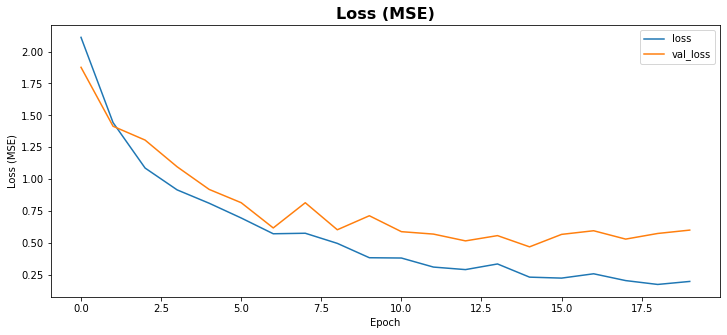

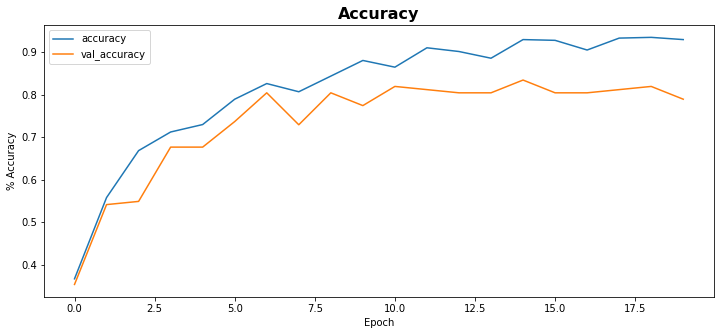

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In [13]:
def get_model_imagenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_imagenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

87916544/87910968 [==============================] - 0s 0us/step


In [14]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)


Epoch 1/50
18/18 [==============================] - 268s 14s/step - loss: 2.9959 - accuracy: 0.0395 - val_loss: 2.7951 - val_accuracy: 0.0752
Epoch 2/50
18/18 [==============================] - 86s 5s/step - loss: 2.9034 - accuracy: 0.0548 - val_loss: 2.6355 - val_accuracy: 0.2030
Epoch 3/50
18/18 [==============================] - 86s 5s/step - loss: 2.7832 - accuracy: 0.1107 - val_loss: 2.5353 - val_accuracy: 0.2556
Epoch 4/50
18/18 [==============================] - 86s 5s/step - loss: 2.6922 - accuracy: 0.1582 - val_loss: 2.4202 - val_accuracy: 0.3308
Epoch 5/50
18/18 [==============================] - 85s 5s/step - loss: 2.5800 - accuracy: 0.2059 - val_loss: 2.3798 - val_accuracy: 0.3684
Epoch 6/50
18/18 [==============================] - 86s 5s/step - loss: 2.5196 - accuracy: 0.2024 - val_loss: 2.3270 - val_accuracy: 0.4135
Epoch 7/50
18/18 [==============================] - 86s 5s/step - loss: 2.4199 - accuracy: 0.2616 - val_loss: 2.2660 - val_accuracy: 0.3910
Epoch 8/50
18/18 [

In [15]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('inception_SGD.h5')

Test loss: 1.334947943687439
Test Accuracy: 0.6015037298202515


Confusion Matrix
[[0 0 0 1 1 1 0 2 0 0 3 0 0 0 0 0]
 [0 1 1 0 0 0 0 1 0 0 2 1 1 1 1 0]
 [0 1 3 0 3 2 0 1 2 0 6 2 1 0 1 0]
 [0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 2 0 0 0 1 0 1 0 0 0 1 2 0 2 0]
 [0 1 0 0 0 0 0 0 0 0 3 1 2 0 0 0]
 [0 0 0 0 1 0 0 2 0 0 1 0 0 0 1 0]
 [0 0 1 0 1 0 0 1 0 0 3 2 2 0 0 0]
 [0 1 2 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 3 1 2 1 0 0 0 0 5 1 0 0 1 0]
 [0 0 2 0 0 0 0 2 0 0 1 1 0 0 1 0]
 [0 1 1 1 1 0 0 0 0 0 3 0 1 0 2 0]
 [0 0 1 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 2 4 0 0 0 0 2 0 0 1 0 1 0 1 0]
 [0 0 0 0 1 0 0 1 0 0 1 0 2 0 0 0]]



F1 Score macro 0.07821338803182795
F1 Score micro 0.10526315789473684
F1 Score weighted 0.0924395982444269
accuracy_score  0.10526315789473684
precision_score  0.11006111943611945
recall_score  0.0805239898989899
mean_squared_error  42.96992481203007


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



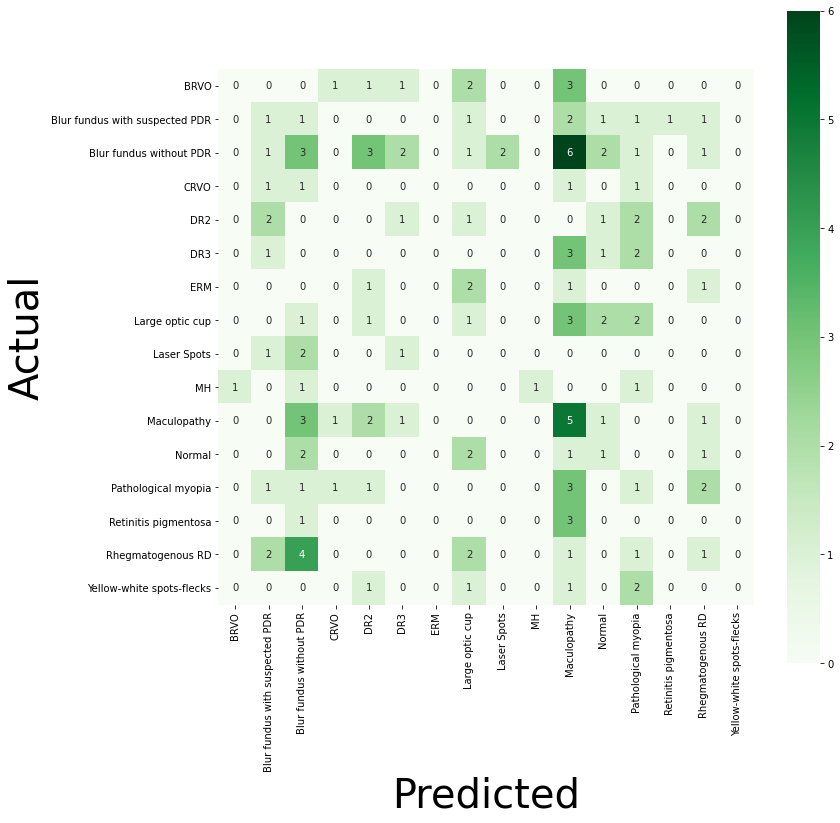

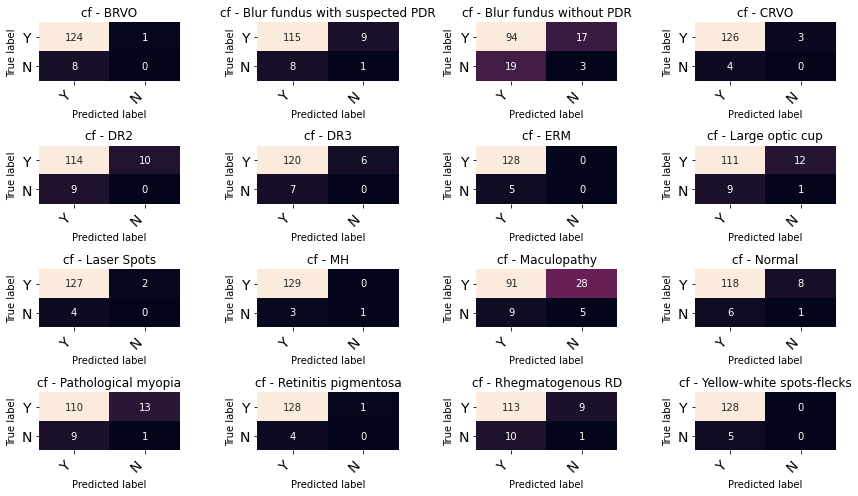

In [16]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
from sklearn.metrics import f1_score

print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

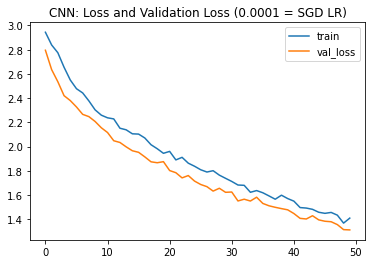

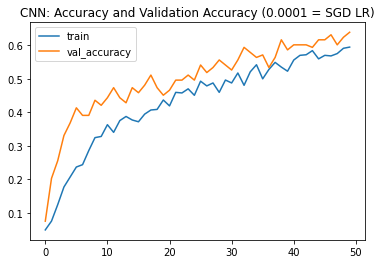

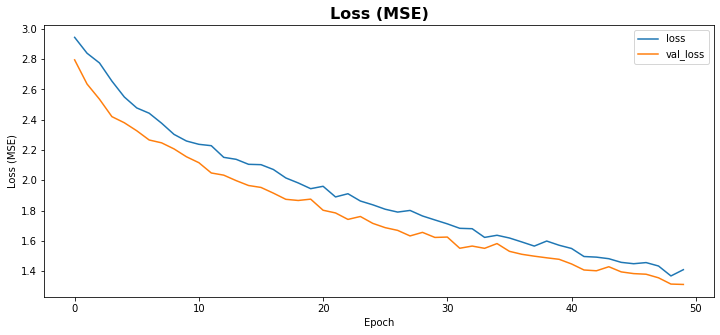

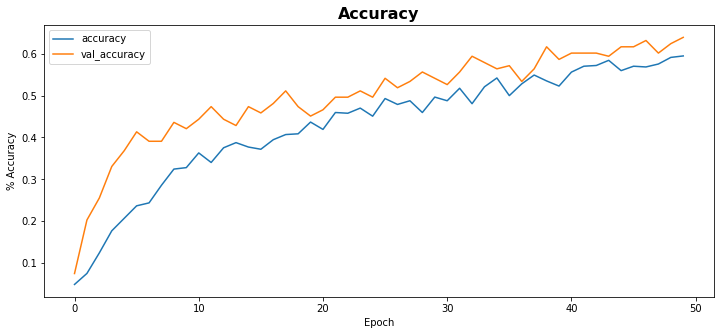

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = SGD LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = SGD LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [18]:
def get_model_imagenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_imagenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [19]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 94s 5s/step - loss: 2.4923 - accuracy: 0.3003 - val_loss: 1.5207 - val_accuracy: 0.5714
Epoch 2/50
18/18 [==============================] - 86s 5s/step - loss: 1.0650 - accuracy: 0.6407 - val_loss: 1.5826 - val_accuracy: 0.6316
Epoch 3/50
18/18 [==============================] - 86s 5s/step - loss: 0.7746 - accuracy: 0.7660 - val_loss: 1.9115 - val_accuracy: 0.6391
Epoch 4/50
18/18 [==============================] - 86s 5s/step - loss: 0.6317 - accuracy: 0.7852 - val_loss: 1.6416 - val_accuracy: 0.6767
Epoch 5/50
18/18 [==============================] - 86s 5s/step - loss: 0.5205 - accuracy: 0.8009 - val_loss: 1.2262 - val_accuracy: 0.7068
Epoch 6/50
18/18 [==============================] - 87s 5s/step - loss: 0.4349 - accuracy: 0.8594 - val_loss: 1.1838 - val_accuracy: 0.7293
Epoch 7/50
18/18 [==============================] - 87s 5s/step - loss: 0.3162 - accuracy: 0.8915 - val_loss: 1.3020 - val_accuracy: 0.6917
Epoch 8/50
18/18 [==

In [20]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('inception_adam.h5')


Test loss: 0.5730491876602173
Test Accuracy: 0.8345864415168762


Confusion Matrix
[[0 0 1 0 0 0 1 0 2 1 0 0 1 0 2 0]
 [1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1]
 [0 0 4 1 1 2 0 3 0 2 1 3 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0]
 [1 0 2 1 2 1 0 0 0 0 1 0 1 0 0 0]
 [0 2 1 0 0 1 0 0 1 0 0 1 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 1 2 1 0 3 1 0 0 0 2 0 0 0 0 0]
 [1 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 1]
 [1 2 3 0 1 1 0 0 0 1 1 0 1 0 1 2]
 [0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 2]
 [1 1 3 0 0 0 0 1 0 1 1 1 1 0 0 0]
 [0 0 1 0 0 0 0 2 0 0 0 0 0 1 0 0]
 [2 0 1 0 0 2 0 0 0 0 1 1 2 2 0 0]
 [0 1 1 0 0 0 0 0 0 0 1 0 0 0 2 0]]



F1 Score macro 0.06203258807995471
F1 Score micro 0.07518796992481203
F1 Score weighted 0.07778839621716306
accuracy_score  0.07518796992481203
precision_score  0.06550324675324674
recall_score  0.06052038239538239
mean_squared_error  49.18796992481203


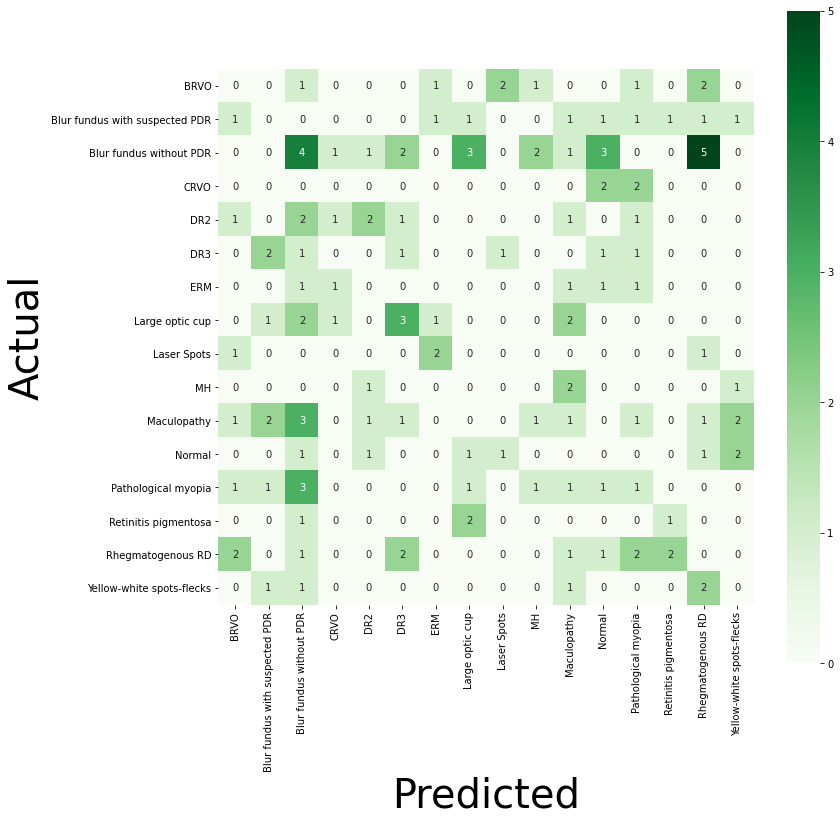

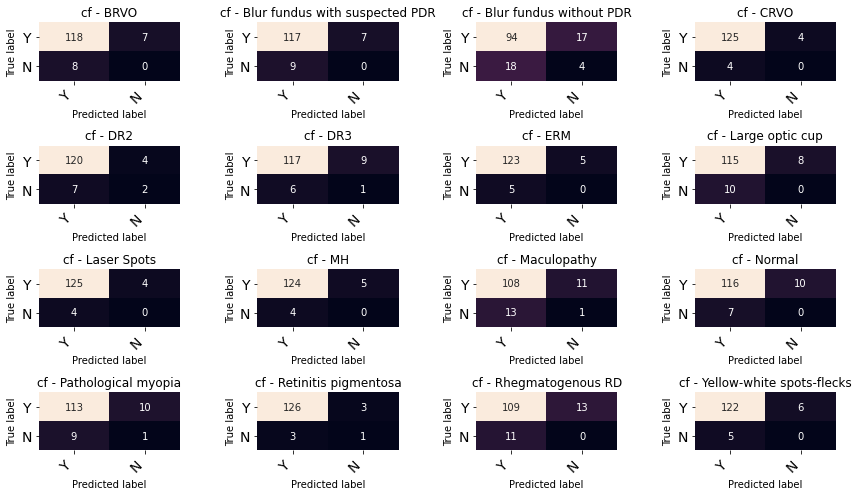

In [21]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
from sklearn.metrics import f1_score

print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()


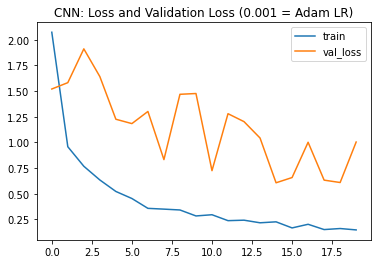

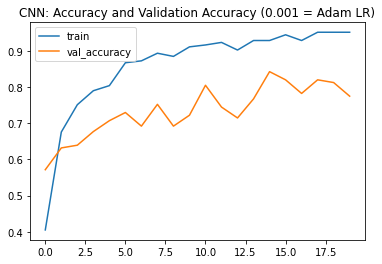

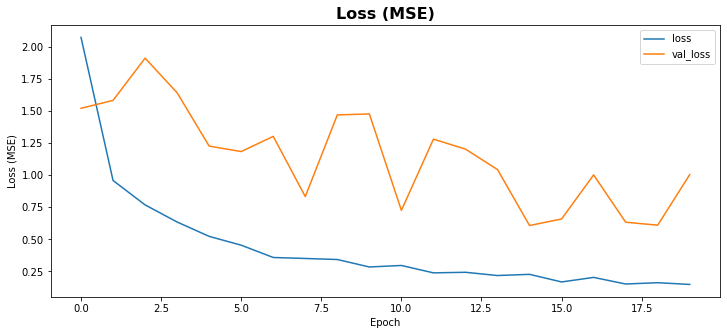

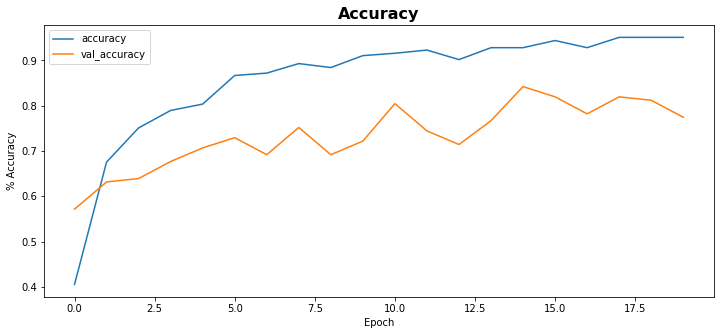

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.001 = Adam LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [23]:
def get_model_imagenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_imagenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [24]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 95s 5s/step - loss: 2.9096 - accuracy: 0.1421 - val_loss: 2.2014 - val_accuracy: 0.2782
Epoch 2/50
18/18 [==============================] - 86s 5s/step - loss: 2.0812 - accuracy: 0.3696 - val_loss: 1.7327 - val_accuracy: 0.5263
Epoch 3/50
18/18 [==============================] - 87s 5s/step - loss: 1.6160 - accuracy: 0.5537 - val_loss: 1.4809 - val_accuracy: 0.5188
Epoch 4/50
18/18 [==============================] - 87s 5s/step - loss: 1.3865 - accuracy: 0.6189 - val_loss: 1.2389 - val_accuracy: 0.6090
Epoch 5/50
18/18 [==============================] - 86s 5s/step - loss: 1.1491 - accuracy: 0.6713 - val_loss: 1.1320 - val_accuracy: 0.6241
Epoch 6/50
18/18 [==============================] - 86s 5s/step - loss: 0.9737 - accuracy: 0.7167 - val_loss: 0.9339 - val_accuracy: 0.6767
Epoch 7/50
18/18 [==============================] - 87s 5s/step - loss: 0.9620 - accuracy: 0.7355 - val_loss: 0.8357 - val_accuracy: 0.7519
Epoch 8/50
18/18 [==

Test loss: 0.4557257294654846
Test Accuracy: 0.8421052694320679
Confusion Matrix
[[1 0 3 0 1 0 0 1 0 0 0 0 1 1 0 0]
 [0 0 0 0 2 0 1 1 1 0 2 0 0 1 0 1]
 [2 1 2 0 2 3 0 3 0 0 4 1 1 1 2 0]
 [0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 1 1 1 1 0 1 0 2 1]
 [1 0 1 0 2 0 1 0 0 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0]
 [1 0 2 0 0 1 0 1 0 1 1 1 2 0 0 0]
 [0 0 2 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 2 2 0 1 1 1 0 0 2 1 1 1 2 0]
 [1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0]
 [0 1 4 0 0 1 0 0 0 1 2 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 1]
 [0 1 2 1 2 0 1 1 1 0 1 0 0 0 1 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0]]



F1 Score macro 0.059532828282828285
F1 Score micro 0.06766917293233082
F1 Score weighted 0.0656489709121288
accuracy_score  0.06766917293233082
precision_score  0.05727137445887446
recall_score  0.06247970779220779
mean_squared_error  46.090225563909776


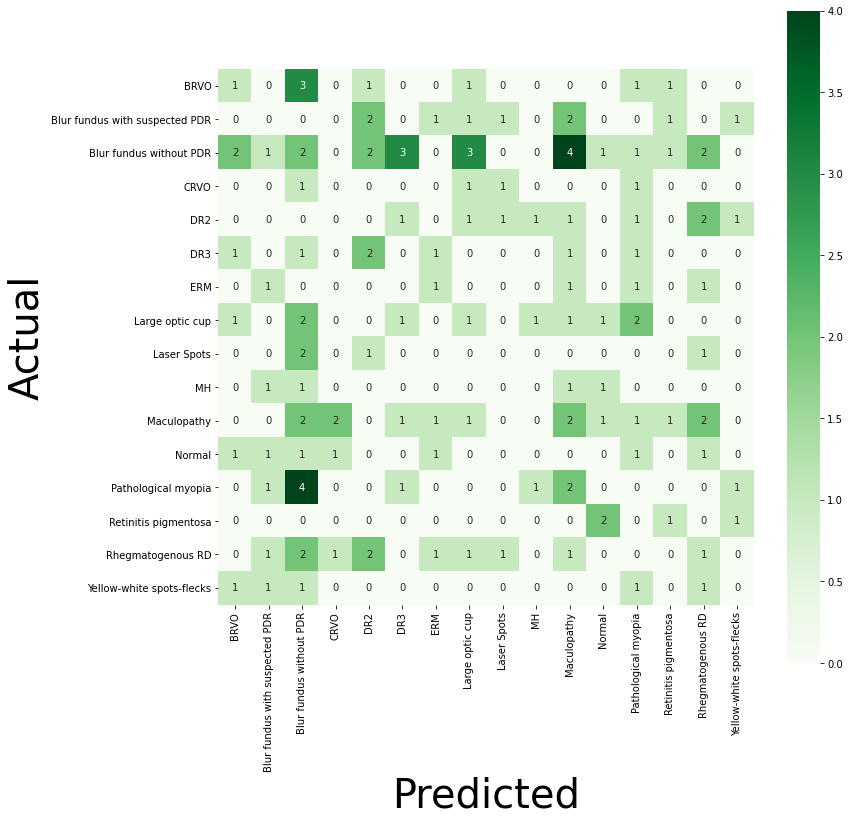

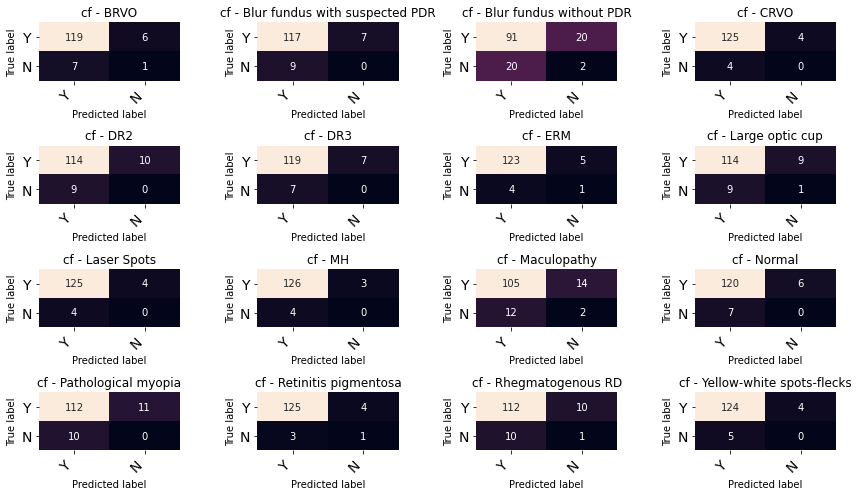

In [25]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
from sklearn.metrics import f1_score

print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

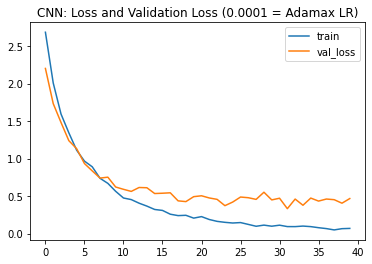

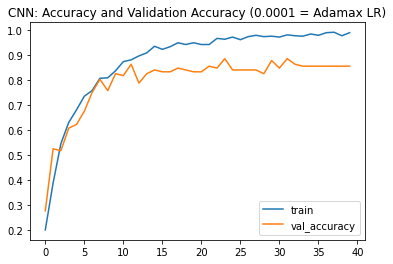

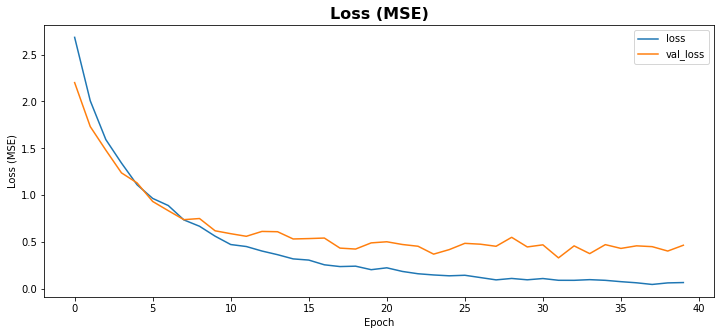

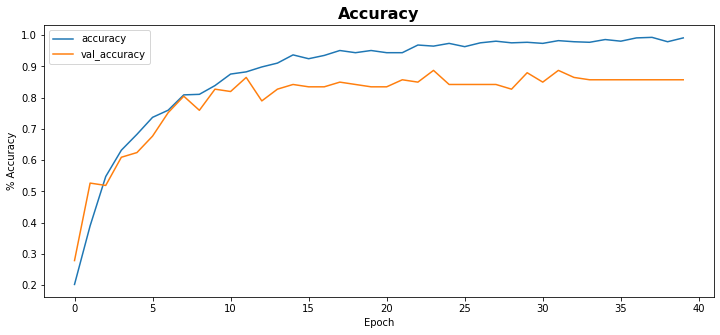

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adamax LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adamax LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [16]:
def get_model_imagenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_imagenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [17]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adamax(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 333s 18s/step - loss: 2.8129 - accuracy: 0.1113 - val_loss: 2.3495 - val_accuracy: 0.2632
Epoch 2/50
18/18 [==============================] - 87s 5s/step - loss: 2.3601 - accuracy: 0.2767 - val_loss: 2.1140 - val_accuracy: 0.3985
Epoch 3/50
18/18 [==============================] - 86s 5s/step - loss: 2.1017 - accuracy: 0.3609 - val_loss: 1.9300 - val_accuracy: 0.4286
Epoch 4/50
18/18 [==============================] - 86s 5s/step - loss: 1.9410 - accuracy: 0.4325 - val_loss: 1.8154 - val_accuracy: 0.4361
Epoch 5/50
18/18 [==============================] - 86s 5s/step - loss: 1.7495 - accuracy: 0.4729 - val_loss: 1.6301 - val_accuracy: 0.5489
Epoch 6/50
18/18 [==============================] - 86s 5s/step - loss: 1.7161 - accuracy: 0.4959 - val_loss: 1.5564 - val_accuracy: 0.5414
Epoch 7/50
18/18 [==============================] - 86s 5s/step - loss: 1.5767 - accuracy: 0.4919 - val_loss: 1.4247 - val_accuracy: 0.6015
Epoch 8/50
18/18 [

Test loss: 0.5579308867454529
Test Accuracy: 0.8571428656578064
Confusion Matrix
[[2 0 2 0 1 0 1 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 2 0 0 2 1 2 1 0 1]
 [0 1 4 1 2 0 1 0 0 1 4 2 1 0 4 1]
 [0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0]
 [0 0 1 0 0 1 1 2 1 0 2 0 0 0 1 0]
 [0 0 0 1 1 0 0 2 0 0 1 1 1 0 0 0]
 [0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1]
 [0 0 2 0 1 1 1 1 0 0 1 0 2 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 2 0 0]
 [0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0]
 [1 2 4 0 0 1 1 1 1 0 1 0 0 0 2 0]
 [0 1 1 0 0 0 2 0 0 0 1 0 1 0 1 0]
 [0 1 0 1 0 1 0 0 1 1 3 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1]
 [1 1 2 0 1 0 0 1 1 2 0 0 0 0 1 1]
 [0 1 2 0 0 0 1 0 0 0 0 0 0 0 1 0]]



F1 Score macro 0.05390421266030794
F1 Score micro 0.07518796992481203
F1 Score weighted 0.07918769434571318
accuracy_score  0.07518796992481203
precision_score  0.06357074298250769
recall_score  0.04963474025974026
mean_squared_error  48.150375939849624


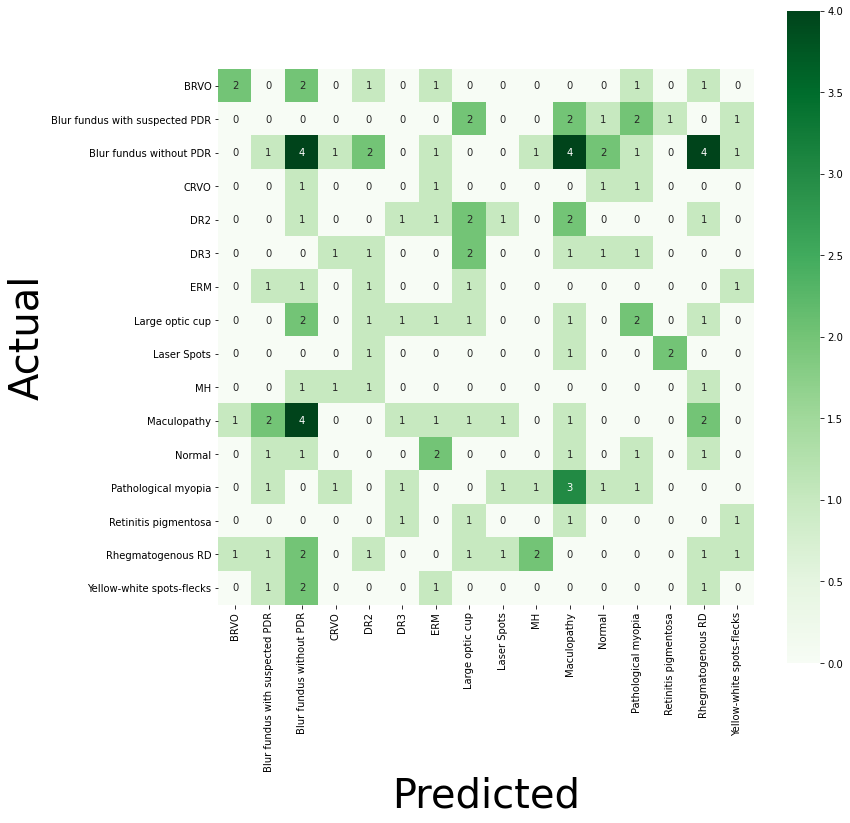

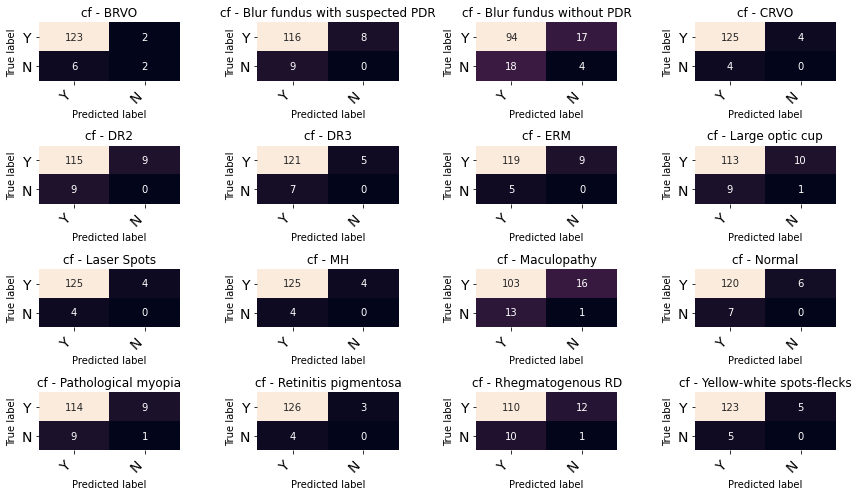

In [18]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

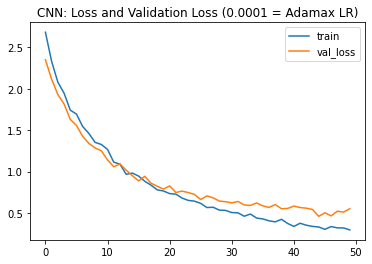

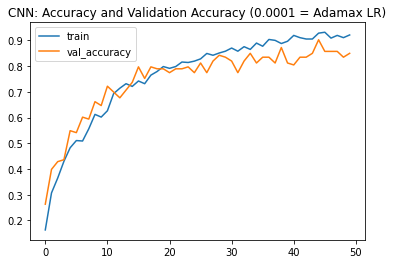

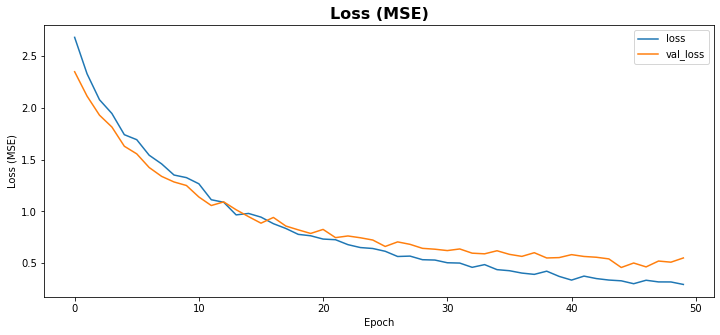

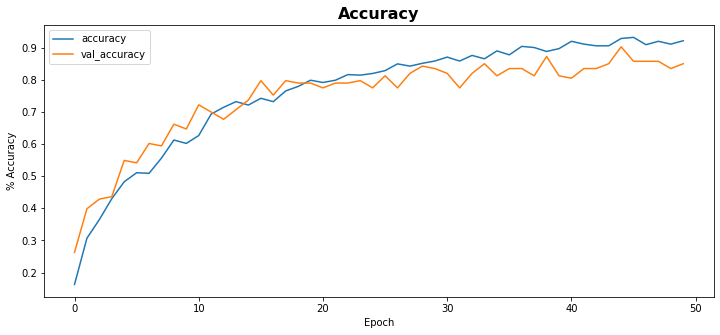

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adamax LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adamax LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [20]:
def get_model_imagenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_imagenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [21]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 94s 5s/step - loss: 2.6706 - accuracy: 0.1984 - val_loss: 1.9473 - val_accuracy: 0.4361
Epoch 2/50
18/18 [==============================] - 85s 5s/step - loss: 1.8079 - accuracy: 0.4904 - val_loss: 1.6316 - val_accuracy: 0.5263
Epoch 3/50
18/18 [==============================] - 86s 5s/step - loss: 1.5598 - accuracy: 0.4894 - val_loss: 1.3591 - val_accuracy: 0.5940
Epoch 4/50
18/18 [==============================] - 86s 5s/step - loss: 1.2168 - accuracy: 0.6588 - val_loss: 1.1912 - val_accuracy: 0.6541
Epoch 5/50
18/18 [==============================] - 86s 5s/step - loss: 1.0618 - accuracy: 0.7067 - val_loss: 1.0404 - val_accuracy: 0.7143
Epoch 6/50
18/18 [==============================] - 85s 5s/step - loss: 0.9392 - accuracy: 0.7408 - val_loss: 0.9295 - val_accuracy: 0.7444
Epoch 7/50
18/18 [==============================] - 85s 5s/step - loss: 0.8085 - accuracy: 0.7666 - val_loss: 0.8896 - val_accuracy: 0.7368
Epoch 8/50
18/18 [==

Test loss: 0.5049740672111511
Test Accuracy: 0.8345864415168762
Confusion Matrix
[[0 0 2 0 0 0 1 1 0 0 1 0 1 0 1 1]
 [0 0 2 1 0 0 0 2 0 0 1 0 2 1 0 0]
 [2 1 4 0 0 1 1 0 1 2 3 1 3 0 2 1]
 [0 1 0 0 0 0 0 0 2 0 1 0 0 0 0 0]
 [0 1 2 1 0 0 1 0 0 0 0 1 0 1 1 1]
 [0 0 0 0 0 0 0 1 0 1 1 0 1 0 3 0]
 [0 0 2 0 1 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 1 0 3 0 2 2 1 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0]
 [0 2 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [1 2 2 0 1 3 1 1 0 0 0 0 0 2 1 0]
 [0 1 2 0 1 0 0 1 0 0 1 0 0 0 1 0]
 [0 1 1 1 0 1 0 0 0 1 0 0 3 0 0 2]
 [1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0]
 [1 0 2 0 1 2 0 2 0 1 1 1 0 0 0 0]
 [0 0 0 0 2 0 1 1 0 0 0 0 0 0 1 0]]


Text(0.5, 145.31999999999996, 'Predicted')

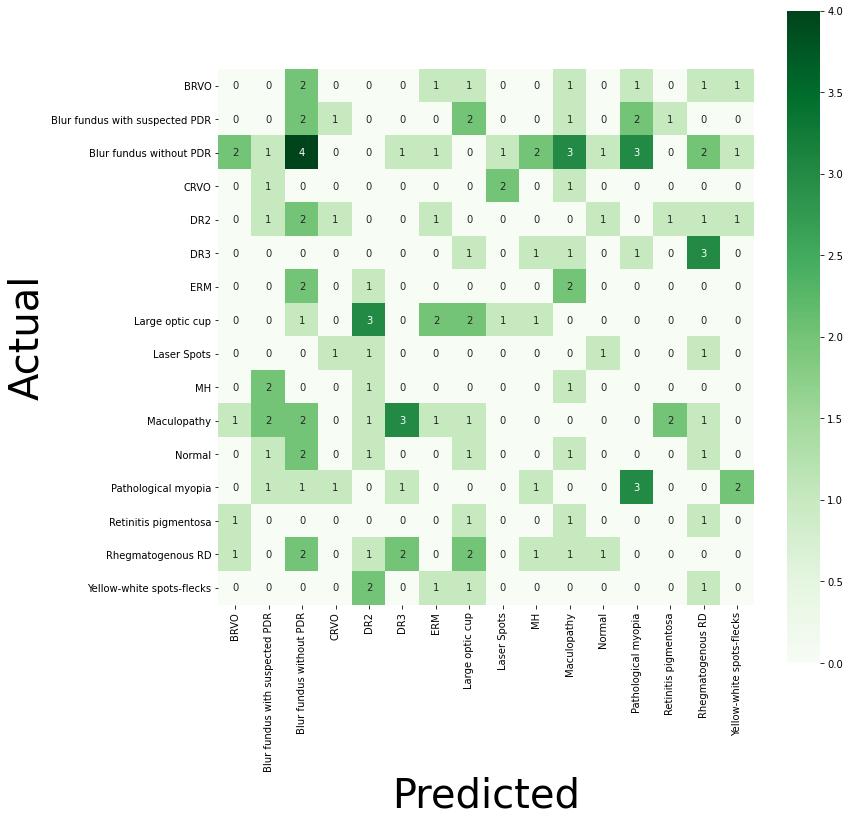

In [22]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('inception_adam.h5')
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)







F1 Score macro 0.04201839826839827
F1 Score micro 0.06766917293233082
F1 Score weighted 0.06773427074178955
accuracy_score  0.06766917293233082
precision_score  0.04166666666666667
recall_score  0.04261363636363637
mean_squared_error  48.5187969924812


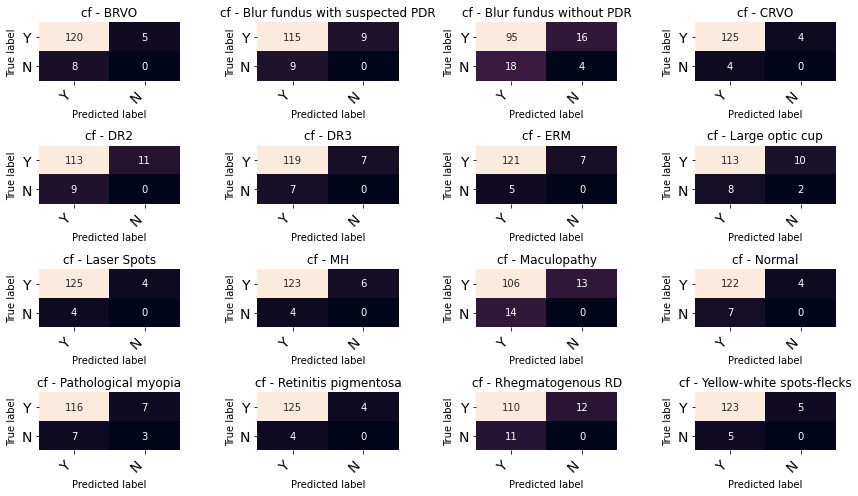

In [23]:
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("cf - " + class_label)
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

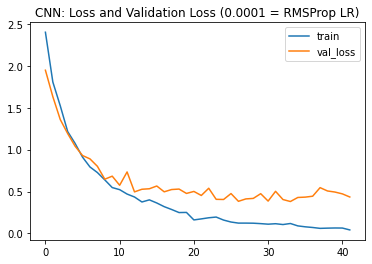

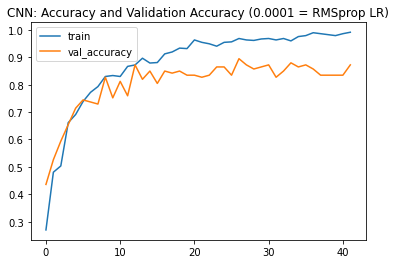

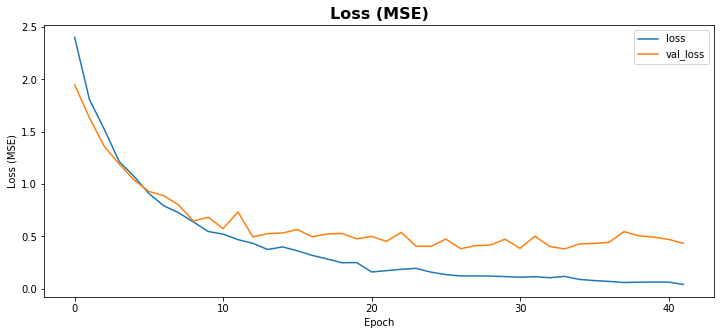

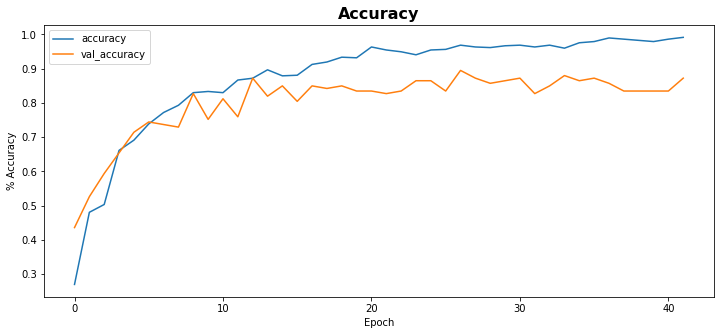

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = RMSProp LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = RMSprop LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [13]:
def get_model_imagenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_imagenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [14]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.RMSprop(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 273s 15s/step - loss: 4.1537 - accuracy: 0.2718 - val_loss: 1.6364 - val_accuracy: 0.5564
Epoch 2/50
18/18 [==============================] - 88s 5s/step - loss: 1.2180 - accuracy: 0.6195 - val_loss: 1.9507 - val_accuracy: 0.5714
Epoch 3/50
18/18 [==============================] - 88s 5s/step - loss: 0.8993 - accuracy: 0.7296 - val_loss: 3.6259 - val_accuracy: 0.4962
Epoch 4/50
18/18 [==============================] - 87s 5s/step - loss: 0.7564 - accuracy: 0.7350 - val_loss: 1.6372 - val_accuracy: 0.6842
Epoch 5/50
18/18 [==============================] - 88s 5s/step - loss: 0.5202 - accuracy: 0.8414 - val_loss: 1.7076 - val_accuracy: 0.6692
Epoch 6/50
18/18 [==============================] - 88s 5s/step - loss: 0.4190 - accuracy: 0.8394 - val_loss: 0.8803 - val_accuracy: 0.7820
Epoch 7/50
18/18 [==============================] - 87s 5s/step - loss: 0.3945 - accuracy: 0.8643 - val_loss: 1.5171 - val_accuracy: 0.7293
Epoch 8/50
18/18 [

In [15]:
  def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("cf - " + class_label)


Test loss: 1.0754605531692505
Test Accuracy: 0.7969924807548523
Confusion Matrix
[[0 0 0 0 0 1 0 2 0 1 2 0 0 0 2 0]
 [0 0 3 0 1 0 0 0 0 0 2 0 0 0 3 0]
 [2 0 7 0 1 2 1 0 0 1 4 1 0 0 2 1]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 1 1 0]
 [1 2 0 0 1 0 0 0 0 0 2 0 2 1 0 0]
 [0 1 2 0 1 0 0 2 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0]
 [0 1 2 0 0 0 0 3 0 0 0 1 3 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1]
 [0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1]
 [0 0 2 0 0 0 0 2 2 1 3 0 1 1 0 2]
 [0 1 0 2 0 0 0 0 0 0 1 0 0 1 1 1]
 [1 0 1 0 1 1 2 0 0 0 3 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 2 0 1 0 0 0]
 [0 1 1 1 0 0 1 0 1 0 1 1 2 0 1 1]
 [1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0]]



F1 Score macro 0.06189486664230909
F1 Score micro 0.11278195488721804
F1 Score weighted 0.1093169533259528
accuracy_score  0.11278195488721804
precision_score  0.060464015151515144
recall_score  0.06465548340548341
mean_squared_error  42.13533834586466


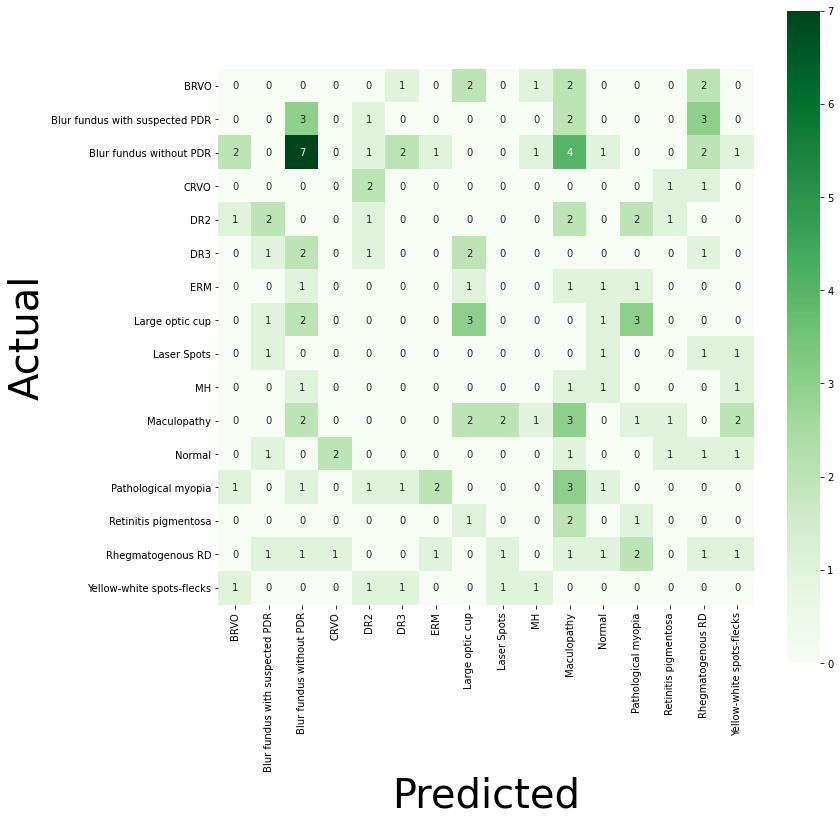

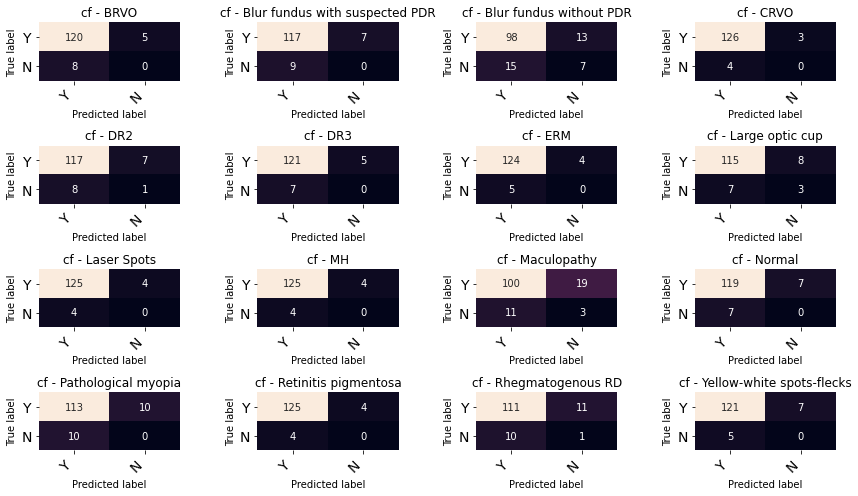

In [16]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
from sklearn.metrics import f1_score

print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()